In [32]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
from rum.basics import matprint
from rum.grid import UniformGrid, Field
from rum.operators import DX, DY, DIFF, LAPL

# Aufgabe 1


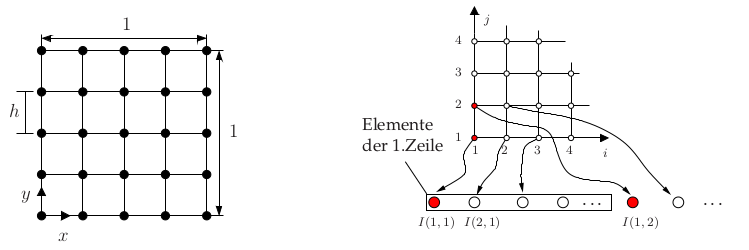

## a)
Generate a uniform grid

In [33]:
grid = UniformGrid(10.0,10.0,0.01)
print(grid[0,1])
print(grid[5,5])
print(grid[9,9])

(0.0, 0.1)
(0.5, 0.5)
(0.9, 0.9)


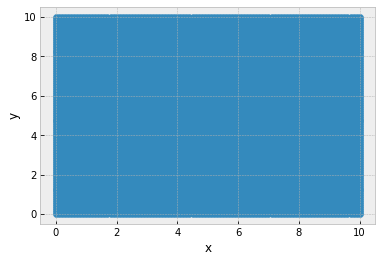

In [34]:
grid.plot().show()

## b)
Discrete Matrix operator DX

4.0


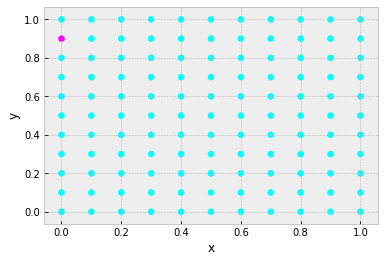

In [77]:
field = Field(1.0,1.0,0.1)
# assign value
field[0,9] = 4
# get value
print(field[0,9])
field.plot().show()

In [75]:
print(field.values)
print(field.asvector())

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.        ]
 [1.         1.00250313 1.00501252 1.0075282  1.01005017 1.01257845
  1.01511306 1.01765402 1.02020134 1.02275503 1.02531512 1.02788162
  1.03045453 1.03303389 1.03561971 1.038212   1.04081077 1.04341606
  1.04602786 1.0486462  1.0512711 ]
 [1.         1.00501252 1.01005017 1.01511306 1.02020134 1.02531512
  1.03045453 1.03561971 1.04081077 1.04602786 1.0512711  1.05654061
  1.06183655 1.06715902 1.07250818 1.07788415 1.08328707 1.08871707
  1.09417428 1.09965886 1.10517092]
 [1.         1.0075282  1.01511306 1.02275503 1.03045453 1.038212
  1.04602786 1.05390256 1.06183655 1.06983026 1.07788415 1.08599867
  1.09417428 1.10241144 1.11071061 1.11907226 1.12749685 1.13598487
  1.14453678 1.15315308 1.16183424]
 [1.         1.01005017 1.02020134 1.03045453 1.04081077 1.0512711

## c)

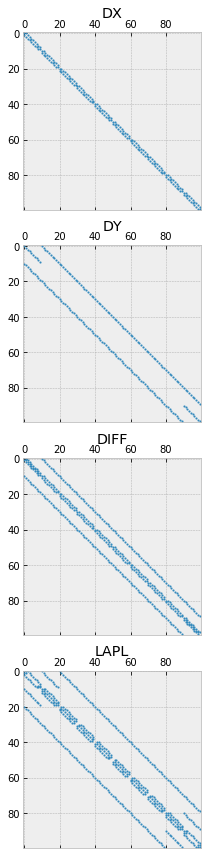

In [37]:
N = 10
spyfig, axarr = plt.subplots(4,1,figsize=(5,15))
axarr[0].spy(DX(N),precision=0.01,markersize=1)
axarr[0].set_title('DX')
axarr[1].spy(DY(N),precision=0.01,markersize=1)
axarr[1].set_title('DY')
axarr[2].spy(DIFF(N),precision=0.01,markersize=1)
axarr[2].set_title('DIFF')
axarr[3].spy(LAPL(N),precision=0.01,markersize=1)
axarr[3].set_title('LAPL')
plt.show()

## d)
Siehe b)

## e)

In [85]:
field = Field(1.0,1.0,0.005)

def f1(x,y):
    return np.exp(x*y)

def f2(x,y):
    return np.cos(10*x*y)

thisfunc = f1

Nx, Ny = field.shape
for i in range(Nx):
    for j in range(Nx):
        x,y = field.getxy(i,j)
        field[i,j] = thisfunc(x,y)

        

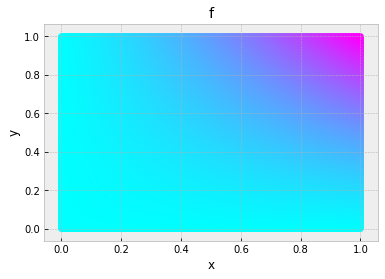

In [79]:
plot = field.plot()
plot.title("f")
plot.show()

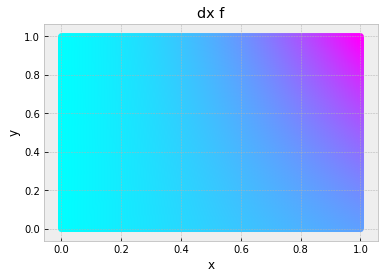

In [80]:
plot = field.dx().plot()
plot.title("dx f")
plot.show()

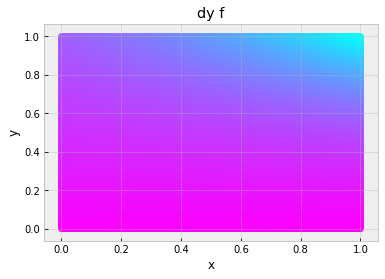

In [81]:
plot = field.dy().plot()
plot.title("dy f")
plot.show()

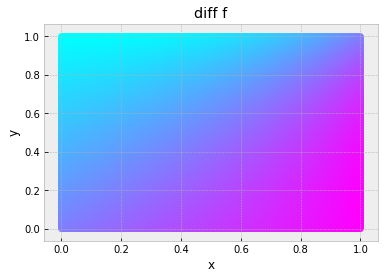

In [82]:
plot = field.diff().plot()
plot.title("diff f")
plot.show()

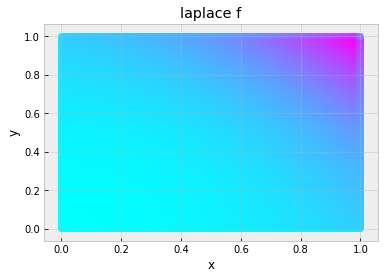

In [83]:
plot = field.lapl().plot()
#plot.title("laplace f")
#plot.show()

KeyboardInterrupt: 

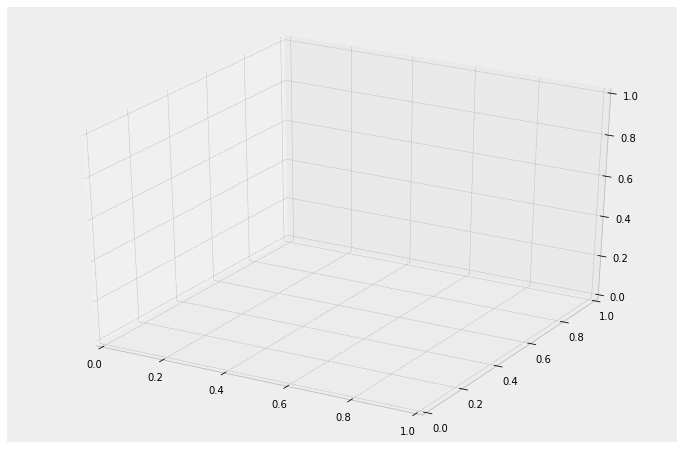

In [86]:
# 3d plot
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

gridpoints = [field.lapl().getxy(i, j) for i in range(field.lapl().N)
                      for j in range(field.lapl().N)]
plot_x = [gp[0] for gp in gridpoints]
plot_y = [gp[1] for gp in gridpoints]


# Make data.
x = plot_x
y = plot_y
Z = field.lapl().values

# Plot the surface.
surf = ax.scatter3D(x, y, Z, cmap='cool',
                       linewidth=0, antialiased=False)



plt.show()


In [ ]:
matprint(field.lapl().values, fmt=".2e")